## a-AlphaBio homework 
### Mark Thompson
### Started April 29, 2024 

In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pk
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline


----
# t-SNE analysis

The transformer-based models should have learned relationships between the elements of the sequence.  See how this appears in t-SNE plots

In [3]:
%autoreload
from torch.utils.data import DataLoader
from models.tform import TFormMLP_Lightning
from datasets.scFv_diy_dataset_pretrain import scFv_diy_pretrain_Dataset as dataset
import os
import yaml
import pytorch_lightning as pl
import torch

# Read the config
config_path = './config/tform_params.yaml'  
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

model_config = config['model_params']
train_config = config['train_params']    
test_config = config['test_params']
print(model_config)
print(train_config)
print(test_config)

pl.seed_everything(config['seed'])



Seed set to 3407


{'block_size': 248, 'vocab_size': 25, 'num_heads': 16, 'dim_head': 64, 'num_layers': 12, 'emb_dim': 768}
{'train_type': 'mask_lang_model', 'loss_type': 'mse', 'sequence_regularize': False, 'seq_mask_prob': 0.05, 'freeze_base_model': False, 'mask_prob': 0.4, 'tform_dropout': 0.1, 'emb_dropout': 0.1, 'mlp_dropout': 0.1, 'accelerator': 'mps', 'devices': 1, 'precision': '16-mixed', 'batch_size': 36, 'accumulate_grad_batches': 25, 'num_workers': 10, 'grad_norm_clip': 1.0, 'num_epochs': 1000, 'log_dir': '../lightning_logs/tform_mlp_model/pretrain/big2/chain_id/paired_2_set/', 'train_data_path': '../data/oas_2/paired/paired_2_train_set.csv', 'val_data_path': '../data/oas_2/paired/paired_2_val_set.csv', 'checkpoint_name': '../lightning_logs/tform_mlp_model/pretrain/big2/chain_id/paired_2_set/version_0/checkpoints/epoch=7-step=2500-val_loss=0.63-loss=0.57.ckpt', 'learning_rate': 0.0001, 'lr_gamma': 0.9995, 'betas': [0.9, 0.98], 'eps': 1e-06, 'checkpoint_every_n_train_steps': 100, 'save_top_k': 

3407

In [4]:
#----------------------------------------------------------
# Load the dataset and dataloaders
#----------------------------------------------------------
test_data_path = './data/oas_2/paired/paired_2_val_set.csv'
test_dataset = dataset(train_config, model_config['block_size'], test_data_path, regularize=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=5) #256) #train_config['batch_size'])

#----------------------------------------------------------
# Load pre-trained model
#----------------------------------------------------------
checkpoint_name = './lightning_logs/tform_mlp_model/pretrain/big2/chain_id/paired_2_set/version_1/checkpoints/epoch=60-step=8000-val_loss=0.44-loss=0.43.ckpt' 
model = TFormMLP_Lightning.load_from_checkpoint(checkpoint_path=checkpoint_name, model_config=model_config, config=train_config)

# register a forward hook to pick out the output tensors for the attention blocks
# feats = {} # an empty dictionary
# def hook_fn(m, inp, op):
#    feats['feat'] = op.detach()
#    return feats

# The hook will grab the output of the final Encoder layer's attention block
# model.model.transformer.encoders[-1].attn_block.attend.register_forward_hook(hook_func)

class SaveOutput:
   def __init__(self):
      self.outputs = []

   def __call__(self, module, module_in, module_out):
      self.outputs.append(module_out)

   def clear(self):
      self.outputs = []

save_output = SaveOutput()

from models.model_parts import AttentionBlock



hook_handles = []
for name, module in model.named_modules():
      if name.find('attend') != -1:
         print(name, ', module:', module)
         handle = module.register_forward_hook(save_output)
         hook_handles.append(handle)
      


DIY scFv sequences created by this dataset class
reading the data from: ./data/oas_2/paired/paired_2_val_set.csv
vocabulary: ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'MASK', 'PAD', 'SEP']
data has 26356 rows, 25 vocab size
Using fixed linker sequence: SSGGGGSGGGGSGGGGSE
Consider using a much simpler regression head!!!!
Regression head is ResidualMLP
making residual mlp layer in_dim, out_dim: 768 768
making residual mlp layer in_dim, out_dim: 768 768
making residual mlp layer in_dim, out_dim: 768 768
making final dense mlp layer in_dim, out_dim: 768 1
model.transformer.encoders.0.attn_block.attend , module: Softmax(dim=-1)
model.transformer.encoders.1.attn_block.attend , module: Softmax(dim=-1)
model.transformer.encoders.2.attn_block.attend , module: Softmax(dim=-1)
model.transformer.encoders.3.attn_block.attend , module: Softmax(dim=-1)
model.transformer.encoders.4.attn_block.attend , module: Softmax(dim=-1)
model.

In [5]:
it = iter(test_loader)
batch = next(it)
# x, x2, x3, y, name = batch
x, chain, mask, y, name = batch
print('x shape:', x.shape, ', chain shape:', chain.shape, ', mask shape:', mask.shape, ', y shape:', y.shape)

y_hat, loss, trans_out = model(x.to(model.device), chain.to(model.device), mask.to(model.device))
print('y_hat shape:', y_hat.shape, ', trans_out shape', trans_out.shape)

print('number of outputs saved by hooks:', len(save_output.outputs))
# print('hook function results. feats[feat].shape:', feats['feat'].shape)

x shape: torch.Size([5, 248]) , chain shape: torch.Size([5, 248]) , mask shape: torch.Size([5, 248]) , y shape: torch.Size([5, 1])
y_hat shape: torch.Size([5, 248, 25]) , trans_out shape torch.Size([5, 248, 768])
number of outputs saved by hooks: 12


In [6]:
print(save_output.outputs[0].shape)

torch.Size([5, 16, 248, 248])


In [17]:
# import torch library
import torch
from torch.nn.functional import normalize

# define a torch tensor
t = torch.tensor([1., 2., 3., -2., -5.])

# print the above tensor
print("Tensor:", t)

# normalize the tensor
t1 = normalize(t, p=1.0, dim = 0)
t2 = normalize(t, p=2.0, dim = 0)

print(torch.sum(torch.abs(t1)))
print(torch.sum(torch.abs(t2)))

# print normalized tensor
print("Normalized tensor with p=1:", t1)
print("Normalized tensor with p=2:", t2)

Tensor: tensor([ 1.,  2.,  3., -2., -5.])
tensor(1.)
tensor(1.9825)
Normalized tensor with p=1: tensor([ 0.0769,  0.1538,  0.2308, -0.1538, -0.3846])
Normalized tensor with p=2: tensor([ 0.1525,  0.3050,  0.4575, -0.3050, -0.7625])


heads shape: torch.Size([5, 16, 248, 248])
norm_head shape: torch.Size([248, 248])
sum of one of the norm_head's rows: tensor(1.0000)


AttributeError: 'str' object has no attribute 'items'

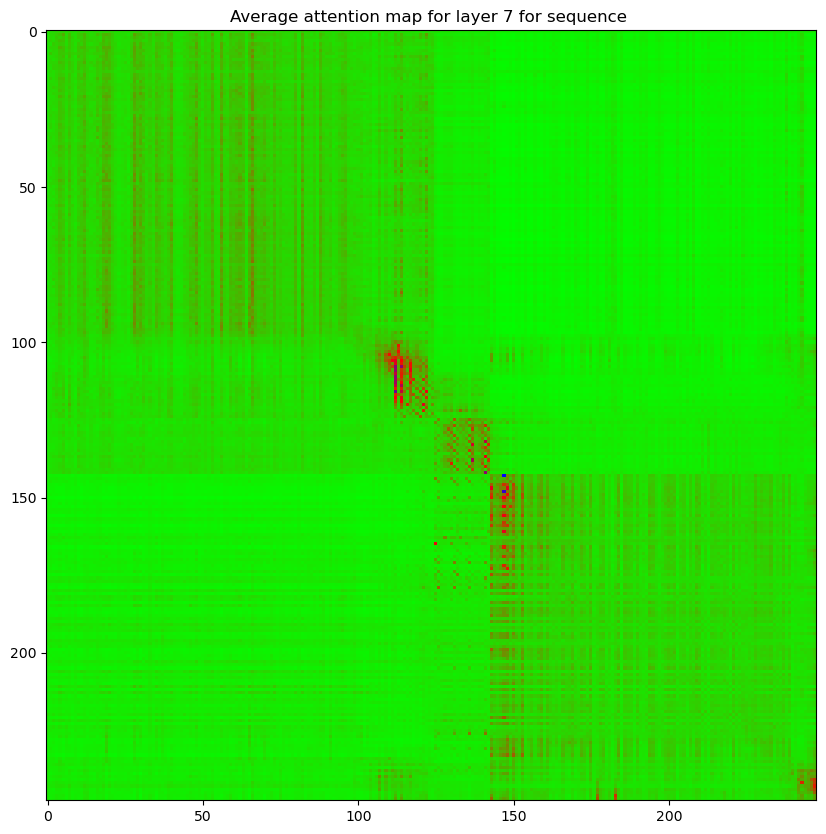

In [39]:
#
# Print the averaged attention map for all encoder layers
#
import matplotlib.colors as colors

seq_idx = 0  # The specific sequence we'll examine
layer_idx = 7

heads = save_output.outputs[layer_idx]
print('heads shape:', heads.shape)
# head = heads[seq_idx, :,:,:].cpu()
# print('head shape:', head.shape)


# calc the mean-head over all heads
h1 = torch.sum(heads[seq_idx, :, :, :], dim=0)
norm_head = (torch.nn.functional.normalize(h1, p=1, dim=1)).cpu().detach()
print('norm_head shape:', norm_head.shape)
sum = torch.sum(norm_head[10,:])
print('sum of one of the norm_head\'s rows:', sum)

plt.figure(figsize=(10,10))
cmap = plt.get_cmap('brg_r') #brg_r') #viridis')
plt.imshow(norm_head, cmap=cmap)  
plt.title('Average attention map for layer ' + str(layer_idx) + ' for sequence ' + str(seq_idx))
xmin = 0
xmax = 248
plt.xlim(xmin, xmax) 
plt.ylim(xmax, xmin)
plt.xlabel('aa residue')
plt.ylabel('aa residue')
# plt.xticks(torch.arange(1, 60, 2).tolist())
# plt.yticks([48, 49, 50])


num rows: 3 , num cols: 4
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])
heads shape: torch.Size([5, 16, 248, 248])


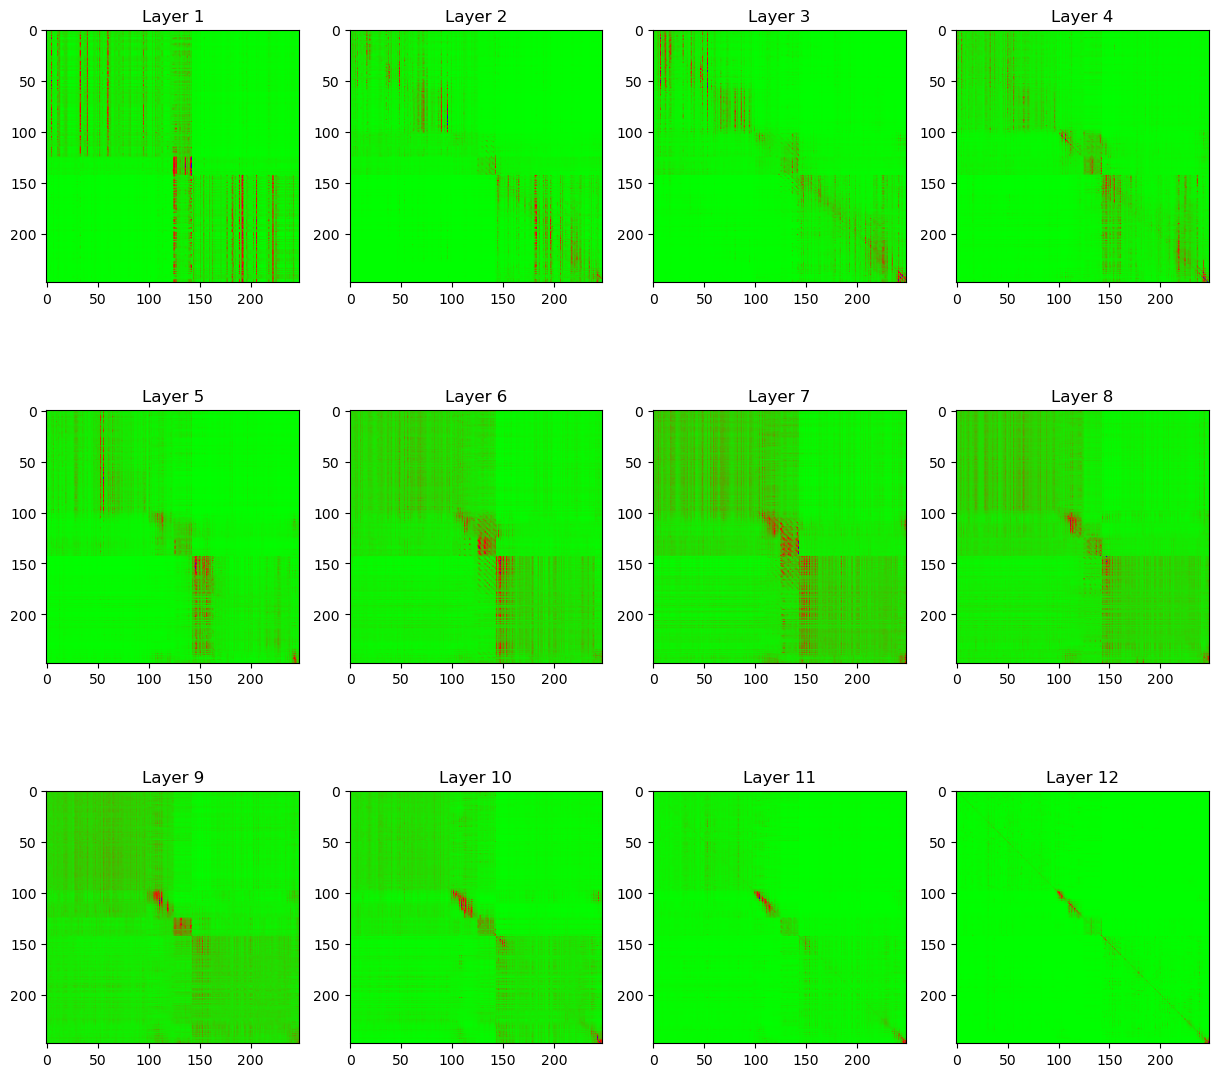

In [35]:
#
# Print the averaged attention map for all encoder layers
#
import matplotlib.colors as colors

cols = 4
rows = 3
num_layers = len(save_output.outputs)
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(15,14))
cmap = plt.get_cmap('brg_r') 
seq_idx = 0  # The specific sequence we'll examine

idx = 1
for lidx in range(num_layers):
    heads = save_output.outputs[lidx]
    print('heads shape:', heads.shape)

    # calc the mean-head over all heads in this layer
    h1 = torch.sum(heads[seq_idx, :, :, :], dim=0)
    norm_head = (torch.nn.functional.normalize(h1, p=1, dim=1)).cpu().detach()

    ax = plt.subplot(rows, cols, idx)
    # ax.axis('off')
    plt.imshow(norm_head, cmap=cmap)  
    plt.title('Layer ' + str(lidx+1))
    idx += 1



# plt.figure(figsize=(10,10))
# cmap = plt.get_cmap('brg_r') #brg_r') #viridis')
# plt.imshow(norm_head.numpy(), cmap=cmap)  
# # xticks = torch.arange(xmin, xmax, 2).tolist()
# # plt.colorbar() 
# # plt.title('Attention map for head #2 in the final encoder layer\nfor the first sequence in the batch')  
# # plt.title('Attention map for head #2 in the final encoder layer\nThe linker region\nfor the first sequence in the batch')  
# # plt.title('Attention map for head #2 in the final encoder layer\nHeavy Chain region\nfor the first sequence in the batch')  
# xmin = 0
# xmax = 248
# plt.xlim(xmin, xmax) #60) #248)  #xmin, xmax)
# plt.ylim(xmax, xmin)
# plt.xlabel('aa residue')
# plt.ylabel('aa residue')
# # plt.xticks(torch.arange(1, 60, 2).tolist())
# # plt.yticks([48, 49, 50])

# # for i in range(0, 60):
#     # print('{:.3f}'.format(nhead[49,i]), end=' ')

# # print('{:.2f}'.format([nhead[49, 0:60]]))

In [ ]:

import matplotlib.colors as colors

seq_idx = 1

# 'rgb' is not a valid value for name; supported values are 'Accent',
# 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
# 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 
# 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
# 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 
# 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 
# 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 
# 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 
# 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 
# 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 
# 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
# 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 
# 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 
# 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 
# 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 
# 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
# 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 
# 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 
# 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 
# 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket',
#  'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 
# 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 
# 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 
# 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r

cols = 4
rows = 4
num_heads = 16
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(15,15))
cmap = plt.get_cmap('brg') #viridis') brg_r

idx = 1
for hidx in range(num_heads):
    nhead = heads[seq_idx,hidx,:,:].cpu()  
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    plt.imshow(nhead, cmap=cmap)  
    idx += 1


In [ ]:
from einops import repeat

print('trans_out shape:', trans_out.shape)
b, n, d = trans_out.shape
print('b:', b, ', n:', n, ', d:', d)

ctx_labels = torch.arange(0, model_config['block_size'])
print('ctx_labels shape:', ctx_labels.shape)


# Five types of tokens to distinguish in the tsne plot:
# chain id to distinguish heavy, light, and linker
# 1: heavy chain, 2: light chain, 3: linker.  CLS: 0, PAD: 4
# ctx_cats = torch.ones_like(ctx_labels)  # label everything like it's a non-CDR aa group
# ctx_cats[0] = 0  # the classifier token used in regression
# ctx_cats[29:109] = 2  # the CDR region is aa residues 29-108
labels = chain.squeeze()
print('labels shape:', labels.shape)
# print(labels)

# labels = ctx_cats.repeat(train_config['batch_size'])
# print('labels shape:', labels.shape)

ctx_vectors = torch.reshape(trans_out, (trans_out.shape[0]*trans_out.shape[1], trans_out.shape[2]))
labels = torch.flatten(labels)
print('ctx_vectors shape', ctx_vectors.shape)
print('labels shape', labels.shape)

In [ ]:
# Look at just one sequence
#
num_seqs = 1
labels = ctx_cats.repeat(num_seqs)
print('labels shape:', labels.shape)

idx = 4
one_seq = trans_out[idx:idx+num_seqs]
print('shape one_seq:', one_seq.shape)
new_shape = one_seq.shape[0]*one_seq.shape[1]

ctx_vectors = one_seq
ctx_vectors = torch.reshape(one_seq, (one_seq.shape[0]*one_seq.shape[1], one_seq.shape[2]))
print('ctx_vectors shape', ctx_vectors.shape)

In [ ]:
from sklearn.manifold import TSNE
n_iter = 3000

# 2D
tsne = TSNE(n_components=2, random_state=config['seed'], metric="cosine", n_iter=n_iter, verbose=True)
x_tsne = tsne.fit_transform(ctx_vectors.detach().cpu().numpy())
print('x_tsne shape:', x_tsne.shape)
print(tsne.kl_divergence_)


In [ ]:
from pathlib import Path
path = Path('./misc_analysis/tSNE/tform_mlp/pretrain/big2/chain_id/paired_2_set/')
path.mkdir(parents=True, exist_ok=True)

pk.dump(x_tsne, open(os.path.join(path, 'tsne_10000iter_tform_pretrain_paired2.pkl'), 'wb'))

# x_tsne = pk.load(open('./misc_analysis/tSNE/tform_mlp_v2/tsne_x_10000iter_tform_mlp_v2.pkl', 'rb'))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create an array with three colors
colors = ["#55FF00", "#FF0000", "#0000FF", "#aa00FF",  "#000000"] # rgb, purple, and black
# colors = ["#0000FF", "#A0A0A0", "#FF0000"] # rgb
# Set custom color palette
my_palette = sns.color_palette(colors)
sns.set_palette(my_palette)

fig, ax = plt.subplots(figsize=(10, 8))
x_all = x_tsne[:, 0] 
y_all = x_tsne[:, 1] 
cat_all = labels     
plt.title('t-SNE of transformer model output')  
ax.set_xlabel("t-SNE y")
ax.set_ylabel("t-SNE x")
p = sns.scatterplot(x=x_all, y=y_all, alpha=0.6, ax=ax, palette=sns.color_palette(my_palette), hue=labels, legend=True)

# title
p.legend_.set_title('Token type')
new_labels = ['regression token', 'aa: non-CDR', 'aa: CDR region (29-108)']
new_labels = ['regression token', 'heavy chain', 'light chain', 'linker',  'PAD token']
for t, l in zip(p.legend_.texts, new_labels):
    t.set_text(l)


In [ ]:
# Set the color palette
sns.set_palette(sns.color_palette("Paired"))
# Plot the data, specifying a different color for data points in
# each of the day categories (weekday and weekend)
ax = sns.scatterplot(x='day', y='miles_walked', data=dataset, hue='day_category')
# Customize the axes and title
ax.set_title("Miles walked")
ax.set_xlabel("day")
ax.set_ylabel("total miles")
# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

----
## Analysis of output of attention blocks to see the interactions

### (also, see the BertViz tool:  https://github.com/jessevig/bertviz)

In [ ]:
%autoreload
from torch.utils.data import DataLoader
from models.tform_mlp_v2 import TFormMLP_Lightning_v2
from datasets.scFv_dataset_v2 import scFv_Dataset_v2 as dataset
import os
import yaml
import pytorch_lightning as pl
import torch

# Read the config
config_path = './config/tform_mlp_params.yaml'  
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

model_config = config['model_params']
train_config = config['train_params']    
test_config = config['test_params']
print(model_config)
print(train_config)
print(test_config)

pl.seed_everything(config['seed'])



In [ ]:
#----------------------------------------------------------
# Load the dataset and dataloaders
#----------------------------------------------------------
test_data_path = './data/q_cleaned_4b_test_set.csv'
test_dataset = dataset(train_config, model_config['block_size'], test_data_path, regularize=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=train_config['batch_size'])

#----------------------------------------------------------
# Load pre-trained model
#----------------------------------------------------------
checkpoint_name = './lightning_logs/tform_mlp_model/cleaned-4-data/trained/checkpoints/epoch=316-step=9800-val_loss=0.11-loss=0.05.ckpt' 
model = TFormMLP_Lightning_v2.load_from_checkpoint(checkpoint_path=checkpoint_name, model_config=model_config, config=train_config)


it = iter(test_loader)
batch = next(it)
x, y, name = batch
print('x shape:', x.shape, ', y shape:', y.shape)

y_hat, trans_out = model(x.to(model.device))
print('y_hat shape:', y_hat.shape, ', trans_out shape', trans_out.shape)

In [ ]:
#
# Use forward hooks to pick out the output tensors for the attention blocks
#

feats = {} #an empty dictionary
def hook_func(m , inp ,op):
   feats['feat'] = op.detach()

# it = iter(test_loader)
# batch = next(it)
# x, x2, x3, y, name = batch
y_hat, trans_out = model(x.to(model.device), x2.to(model.device), x3.to(model.device))

print(feats['feat'].shape)

In [ ]:
# Register hooks to pick outputs from specific layers in model

In [ ]:
#
# Print the averaged attention map for all encoder layers
#
import matplotlib.colors as colors

seq_idx = 0  # The specific sequence we'll examine

heads = save_output.outputs[0]
print('heads shape:', heads.shape)
head = heads[seq_idx,7,:,:].cpu()
print('head shape:', head.shape)

sum = torch.sum(head[10,:])
print('sum of one of the head\'s rows:', sum)


# calc the mean-head over all heads
h1 = torch.sum(heads[seq_idx, :, :, :], dim=0)
print('h1 shape:', h1.shape)
norm_head = (torch.nn.functional.normalize(h1, p=1, dim=1)).cpu().detach()
print('norm_head shape:', norm_head.shape)
sum = torch.sum(norm_head[10,:])
print('sum of one of the norm_head\'s rows:', sum)


# h1_colsum = torch.sum(h1, dim=0)
# h1_colsum = torch.nn.functional.normalize(h1_colsum, p=2.0, dim=0)
# print(h1_colsum)
# print(h1_colsum.shape)
# print(h1_colsum[28:112])
# x = np.arange(0, len(h1_colsum)) #28, 112, 1)
# y = h1_colsum.cpu().numpy()
# plt.plot(x,y)

plt.figure(figsize=(10,10))
cmap = plt.get_cmap('brg_r') #brg_r') #viridis')
plt.imshow(norm_head.numpy(), cmap=cmap)  
# xticks = torch.arange(xmin, xmax, 2).tolist()
# plt.colorbar() 
# plt.title('Attention map for head #2 in the final encoder layer\nfor the first sequence in the batch')  
# plt.title('Attention map for head #2 in the final encoder layer\nThe linker region\nfor the first sequence in the batch')  
# plt.title('Attention map for head #2 in the final encoder layer\nHeavy Chain region\nfor the first sequence in the batch')  
xmin = 0
xmax = 248
plt.xlim(xmin, xmax) #60) #248)  #xmin, xmax)
plt.ylim(xmax, xmin)
plt.xlabel('aa residue')
plt.ylabel('aa residue')
# plt.xticks(torch.arange(1, 60, 2).tolist())
# plt.yticks([48, 49, 50])

# for i in range(0, 60):
    # print('{:.3f}'.format(nhead[49,i]), end=' ')

# print('{:.2f}'.format([nhead[49, 0:60]]))